# Method comparisons for inference

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, precision_recall_curve

/tmp/ipykernel_17038/1431029290.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [237]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
import memento
import memento.simulate as simulate

In [238]:
data_path = '/data_volume/memento/simulation/inference/'

### DE

In [239]:
de_norm_adata = sc.read(data_path + 'de_filtered_norm.h5ad')

In [240]:
A_data, B_data = de_norm_adata[de_norm_adata.obs['ct_real'] == 'A'].X, de_norm_adata[de_norm_adata.obs['ct_real'] == 'B'].X
A_data_shuffled, B_data_shuffled = de_norm_adata[de_norm_adata.obs['ct_shuffled'] == 'A'].X.toarray(), de_norm_adata[de_norm_adata.obs['ct_shuffled'] == 'B'].X.toarray()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [241]:
result = pd.read_csv(data_path + 'memento_de.csv')
# shuffled_result = pd.read_csv(data_path + 'memento_de_shuffled.csv')
_, result['ttest'] = stats.ttest_ind(A_data, B_data, equal_var=False)
result['mwu'] = np.array([stats.ranksums(A_data[:, i], B_data[:,i])[1] for i in range(A_data.shape[1])])
_, result['ttest_shuffled'] = stats.ttest_ind(A_data_shuffled, B_data_shuffled, equal_var=False)
result['mwu_shuffled']  = np.array([stats.ranksums(A_data_shuffled[:, i], B_data_shuffled[:,i])[1] for i in range(A_data.shape[1])])

In [242]:
result['null'] = de_norm_adata.var['is_null'].values


In [243]:
result['ttest_fdr'] = memento.util._fdrcorrect(result['ttest'])
result['memento_fdr'] = memento.util._fdrcorrect(result['de_pval'])

(array([ 821.,  685.,  705.,  734.,  661.,  826.,  757.,  622.,  543.,
        1151.]),
 array([7.66719791e-99, 9.99859682e-02, 1.99971936e-01, 2.99957905e-01,
        3.99943873e-01, 4.99929841e-01, 5.99915809e-01, 6.99901777e-01,
        7.99887746e-01, 8.99873714e-01, 9.99859682e-01]),
 <BarContainer object of 10 artists>)

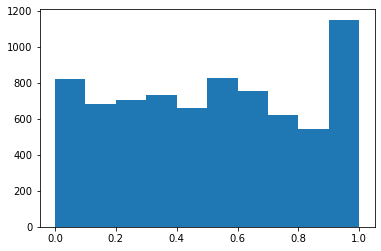

In [244]:
plt.hist(result['ttest'])

(array([ 960.,  818.,  890.,  605.,  656., 1159.,  559.,  623.,  844.,
         391.]),
 array([5.00782092e-08, 1.00000045e-01, 2.00000040e-01, 3.00000035e-01,
        4.00000030e-01, 5.00000025e-01, 6.00000020e-01, 7.00000015e-01,
        8.00000010e-01, 9.00000005e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

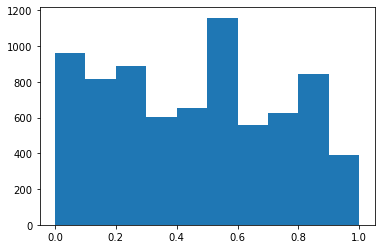

In [245]:
plt.hist(result['de_pval'])

In [246]:
result.shape

(7505, 15)

In [247]:
# for thresh in np.linspace(0.1, 0.9, 10):
    
#     print('ttest', thresh, (1-result.query('ttest_fdr < {}'.format(thresh)).de.mean()))
#     print('mem', thresh, (1-result.query('memento_fdr < {}'.format(thresh)).de.mean()))


Text(0.5, 1.0, 'AUC curve (Differential mean)')

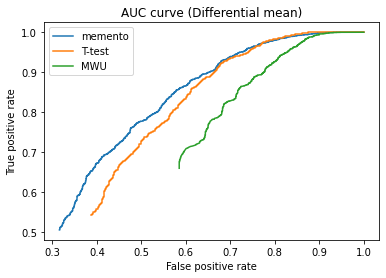

In [265]:
for col in ['de_pval', 'ttest', 'mwu']:
    
    fpr, tpr, t = roc_curve(result['null'], result[col])
    if col != 'mwu':
        plt.plot(fpr[t< 0.5], tpr[t < 0.5], label=col)
    else:
        plt.plot(fpr[t< 0.8], tpr[t < 0.8], label=col)
    
plt.legend(['memento', 'T-test', 'MWU'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC curve (Differential mean)')

Text(0, 0.5, 'Precision')

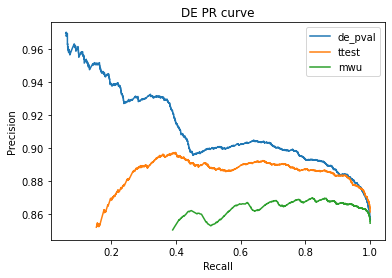

In [266]:
for col in ['de_pval', 'ttest', 'mwu']:
    
    precision, recall, t = precision_recall_curve(result['null'], result[col])
    plt.plot(recall[1:][t < 0.9], precision[1:][t < 0.9], label=col)
    
plt.legend()
plt.title('DE PR curve')
plt.xlabel('Recall'); plt.ylabel('Precision')

In [269]:
def compute_auc_curve(real, shuffled):
    num_thresh = 100
    ts = np.linspace(0.01, 1, num_thresh)
    tpr = np.zeros(num_thresh)
    fpr = np.zeros(num_thresh)
    
    for idx, t in enumerate(ts):
        
        tpr[idx] = (real < t).mean()
        fpr[idx] = (shuffled < t).mean()
    return tpr, fpr, ts

In [270]:
mem_tpr, mem_fpr, ts = compute_auc_curve(result.query('gene < 300').de_pval.values, shuffled_result.de_pval.values)
t_tpr, t_fpr, _ = compute_auc_curve(result.query('gene < 300').ttest.values, result.ttest_shuffled.values)

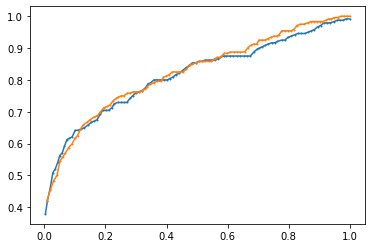

In [271]:
plt.plot(mem_fpr, mem_tpr, '-o', ms=1)
plt.plot(t_fpr, t_tpr, '-o', ms=1)

In [273]:
(result.query('gene < 300')['de_pval'] < 0.05).mean()

0.5208333333333334

In [274]:
(result.query('gene < 300')['mwu'] < 0.05).mean()

0.23333333333333334

In [275]:
(result.query('gene < 300')['ttest'] < 0.05).mean()

0.5458333333333333

In [276]:
(result['ttest_shuffled'] < 0.1).mean()

0.10011982425775529

(array([0.24571369, 0.42999895, 0.5528558 , 0.85385507, 1.08114023,
        1.13028297, 1.27771118, 1.48042497, 1.48042497, 1.48656782]),
 array([0.00128241, 0.10109301, 0.20090361, 0.30071421, 0.40052482,
        0.50033542, 0.60014602, 0.69995663, 0.79976723, 0.89957783,
        0.99938843]),
 <BarContainer object of 10 artists>)

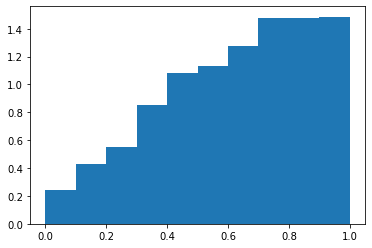

In [151]:
plt.hist(result['mwu_shuffled'], density=True)

In [152]:
(result['ttest_shuffled'] < 0.05).mean()

0.04598405885959534

In [153]:
(result['mwu_shuffled'] < 0.05).mean()

0.008583690987124463

# t-test debugging 


In [5]:
def convert_params_nb(mu, theta):
	"""
	Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

	See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
	"""
	r = theta
	var = mu + 1 / r * mu ** 2
	p = (var - mu) / var
	return r, 1 - p

In [12]:
mu1, mu2 = 0.5, 0.5
theta1, theta2 = 0.01, 3

ttest_pv = []
mwu_pv = []
perc_wins = []
for trial in range(2000):
    data1 = stats.nbinom.rvs(*convert_params_nb(mu1, theta1), size=150)
    data2 = stats.nbinom.rvs(*convert_params_nb(mu2, theta2), size=150)
    ttest_pv.append(stats.ttest_ind(data1, data2, equal_var=False)[1])
    mwu_pv.append(stats.mannwhitneyu(data1, data2, alternative='less')[1])
#     perc_wins.append((data2 > data1).mean())

(array([1.998e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.22033433e-20, 1.12098824e-05, 2.24197648e-05, 3.36296472e-05,
        4.48395296e-05, 5.60494120e-05, 6.72592944e-05, 7.84691768e-05,
        8.96790593e-05, 1.00888942e-04, 1.12098824e-04]),
 <BarContainer object of 10 artists>)

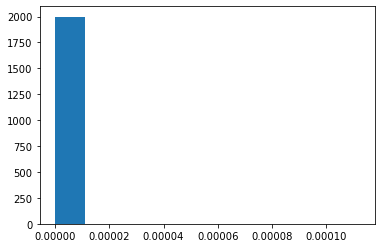

In [13]:
plt.hist(mwu_pv, bins=10)

(array([556.,  82.,  53.,  44.,  68.,  88.,  90.,  87.,  82.,  85.,  91.,
         75.,  97.,  64.,  70.,  73.,  71.,  86.,  74.,  64.]),
 array([9.15601275e-18, 5.00000000e-02, 1.00000000e-01, 1.50000000e-01,
        2.00000000e-01, 2.50000000e-01, 3.00000000e-01, 3.50000000e-01,
        4.00000000e-01, 4.50000000e-01, 5.00000000e-01, 5.50000000e-01,
        6.00000000e-01, 6.50000000e-01, 7.00000000e-01, 7.50000000e-01,
        8.00000000e-01, 8.50000000e-01, 9.00000000e-01, 9.50000000e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

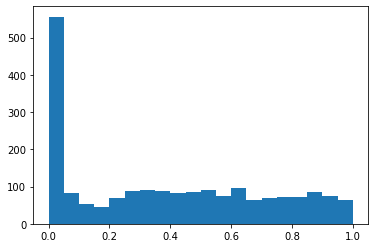

In [14]:
plt.hist(ttest_pv, bins=20)